In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from ipywidgets import IntProgress

import torch.multiprocessing as mp

from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
N = 5000
N_train = 3000
N_test = N - N_train

In [4]:
x1 = np.arange(-1, 1, 2/N)
#x2 = np.random.normal(0, 5, N)

#X = np.vstack((x1, x2)).T
X = x1

# Noise
n1 = np.random.normal(0, 0.4, N)*np.abs(x1**2)
n2 = np.random.normal(0, 1, N)*np.abs(x1**2)
n3 = np.random.normal(0, 2, N)*np.abs(x1**2)

#y1_perfect = x1**2 + 5*x1*x2 + 3*np.abs(x2)

y1_perfect = np.abs(6*x1)*np.sin(x1) + np.sin(12*x1)

#y1_perfect = 2*x1 + x1**2


y1 = y1_perfect + n3

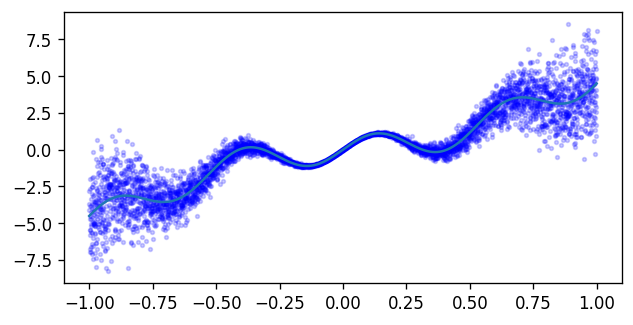

In [5]:
fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.plot(X, y1_perfect)
plt.scatter(X, y1, c='blue', alpha=0.2, s=5)

In [6]:
X = torch.tensor(X, dtype=torch.float32)
y1 = torch.tensor(y1, dtype=torch.float32)

In [7]:
try:
    X.shape[1]
except:
    X = X.unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y1, test_size=0.4, random_state=42)

X_train = torch.tensor(X_train, dtype = torch.float32, requires_grad = True, device = dev)
y_train = torch.tensor(y_train,  dtype = torch.float32, requires_grad = True, device = dev)

X_test = torch.tensor(X_test,  dtype = torch.float32, requires_grad = True, device = dev)
y_test = torch.tensor(y_test,  dtype = torch.float32, requires_grad = True, device = dev)

In [8]:
class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]

        return X_i, y_i

In [9]:
dataset = ArtificialDataset(X, y1)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_test])

In [10]:
BATCH_SIZE = 64

In [11]:
training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=mp.cpu_count())

In [40]:
class VariationalLayer(nn.Module):
    def __init__(self, 
                 input_size, output_size,
                 prior_mu, prior_rho,
                 n_samples
                ):
        super().__init__()
        
        # Bias weight
        input_size = input_size + 1
        
        # Defining Prior distribution (Gaussian)
        self.prior_mu = torch.tensor(prior_mu)
        self.prior_rho = torch.tensor(prior_rho)
        
        # Defining Variational class (Gaussian class)
        self.theta_mu = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -0.5, 0.5)).float()
        self.theta_rho = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -4,-2)).float()
        
        # Defining some constants
        self.logsqrttwopi = torch.log(
            torch.sqrt(2*torch.tensor(torch.pi)))
        self.K = torch.tensor(1)
        
        # Defining number of samples for forward
        self.n_samples = n_samples
    
    def rho_to_sigma(self, theta_rho):
        return torch.log(1 + torch.exp(theta_rho))

    def sample_weight(self, theta_mu, theta_rho):
        w = (theta_mu 
        + self.rho_to_sigma(theta_rho)*torch.randn(
            (self.n_samples, theta_mu.shape[0], theta_mu.shape[1])
        ))
        return w

    def log_prob_gaussian(self, x, mu, rho):
            return (
                - self.logsqrttwopi
                - torch.log(self.rho_to_sigma(rho))
                - ((x - mu)**2)/(2*self.rho_to_sigma(rho)**2)
            ).sum(axis=[1, 2]).mean()
    
    def prior(self, w):
        return self.log_prob_gaussian(
            w, self.prior_mu, self.prior_rho)
        
    def variational(self, w, theta_mu, theta_rho):
        return self.log_prob_gaussian(
            w, theta_mu, theta_rho) 
    
    def kl_divergence_layer(self):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)
        Q = self.variational(w, theta_mu, theta_rho)
        P = self.prior(w)
        KL = Q - P 
        # CHeck if I need to add mean here
        return KL
    
    def forward(self, x_layer):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)    
        x_next_layer = torch.bmm(x_layer, w[:, :-1, :]) + w[:,-1,:].unsqueeze(1)
        return x_next_layer
    
    
    
class VariationalNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_samples, input_size, output_size):
        super().__init__()
        self.n_samples = n_samples
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.Sigmoid()
        self.linear1 = VariationalLayer(input_size, 50, 0, 0.1, n_samples)
        #self.bn = nn.BatchNorm1d(16)
        self.linear2 = VariationalLayer(50, 50, 0, 0.1, n_samples)
        self.linear3 = VariationalLayer(50, output_size, 0, 0.1, n_samples)
    
    # Perform the computation
    def forward(self, x):
        #pdb.set_trace()
        x = torch.unsqueeze(x, 0)
        x = x.expand((self.n_samples, x.shape[1], x.shape[2]))
        x = self.linear1(x)
        #x = self.bn(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.linear3(x)
        return x
    
    def kl_divergence_NN(self):
        kl = (
            self.linear1.kl_divergence_layer() 
            + self.linear2.kl_divergence_layer()
            + self.linear3.kl_divergence_layer()
        )
        return kl

try:
    X_train.shape[1]
except:
    X_train = X_train.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

In [41]:
n_samples = 50
input_size = 1
output_size = 1

In [42]:
h = VariationalNet(n_samples, input_size, output_size).to(dev)
#h1 = ANN(input_size, output_size).to(dev)
#h2 = BayesianNetwork(1).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.01)

mse_loss_mean = nn.MSELoss(reduction='mean')
mse_loss_sum = nn.MSELoss(reduction='sum')

#X_train = torch.unsqueeze(X_train, 2)
index = np.random.randint(0, 800, 5)
x_h = X_train[index]
y_h = y1_train[index]
h.forward(x_h)

In [43]:
BATCH_SIZE = 256

In [44]:
def generate_batches(data):
    batches_idx = []
    n_batches = int(np.floor(data['d'].nunique() / batch_size))
    for i in range(0, n_batches):
        days = data['d'].unique()
        idx = data[data['d'].isin(
            np.random.choice(days, BATCH_SIZE, replace=False))].index.tolist()
        if len(idx) == n_items*batch_size:
            batches_idx.append(idx)
    return batches_idx

In [46]:
def train_one_epoch(epoch_index):
    
    mse_running_loss = 0.
    kl_running_loss = 0.
    
    n = len(training_loader.dataset)

    for i, data in enumerate(training_loader):
        
        x_batch, y_batch = data
        opt_h.zero_grad()

        y_preds = h(x_batch)
        y_preds_mean = y_preds.mean(axis=0).squeeze()

        mse_loss_ = 100*mse_loss_sum(y_preds_mean, y_batch)
        kl_loss_ = (1/50)*h.kl_divergence_NN()
        
        elbo_loss = mse_loss_ + kl_loss_
        elbo_loss.backward()
        
        opt_h.step()
        
        mse_running_loss += mse_loss_.item()
        kl_running_loss += kl_loss_.item()
        
    mse = mse_running_loss/n
    kl = kl_running_loss/n

    return mse, kl

In [47]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 150

for epoch in range(EPOCHS):
    print('------------------EPOCH {}------------------'.format(
        epoch_number + 1))

    h.train(True)
    avg_mse_loss, avg_kl_loss = train_one_epoch(
        epoch_number)
    avg_loss = avg_mse_loss + avg_kl_loss
    
    h.train(False)
    mse_running_loss_v = 0.0
    kl_running_loss_v = 0.0
    
    n = len(validation_loader.dataset)
    
    for i, vdata in enumerate(validation_loader):
        
        x_val_batch, y_val_batch = vdata

        y_val_preds = h(x_val_batch)
        y_val_preds_mean = y_val_preds.mean(axis=0).squeeze()
        
        mse_loss_ = 100*mse_loss_sum(y_val_preds_mean, y_val_batch)
        kl_loss_ = (1/50)*h.kl_divergence_NN()
        elbo_loss = mse_loss_ + kl_loss_
        
        mse_running_loss_v += mse_loss_
        kl_running_loss_v += kl_loss_
        
    avg_vmseloss = (mse_running_loss_v / n).item()
    avg_vklloss = (kl_running_loss_v / n).item()
    
    avg_vloss = avg_vmseloss + avg_vklloss
    
    print('MSE LOSS \t train {} valid {}'.format(
        round(avg_mse_loss, 2), round(avg_vmseloss, 2)))
    print('KL LOSS \t train {} valid {}'.format(
        round(avg_kl_loss, 2), round(avg_vklloss, 2)))
    print('ELBO LOSS \t train {} valid {}'.format(
        round(avg_loss, 2), round(avg_vloss, 2)))

    epoch_number += 1

------------------EPOCH 1------------------
MSE LOSS 	 train 184.1 valid 124.64
KL LOSS 	 train 1.9 valid 1.87
ELBO LOSS 	 train 185.99 valid 126.51
------------------EPOCH 2------------------
MSE LOSS 	 train 127.27 valid 111.9
KL LOSS 	 train 1.77 valid 1.74
ELBO LOSS 	 train 129.04 valid 113.64
------------------EPOCH 3------------------
MSE LOSS 	 train 121.46 valid 107.84
KL LOSS 	 train 1.64 valid 1.62
ELBO LOSS 	 train 123.11 valid 109.46
------------------EPOCH 4------------------
MSE LOSS 	 train 116.04 valid 104.76
KL LOSS 	 train 1.53 valid 1.51
ELBO LOSS 	 train 117.57 valid 106.27
------------------EPOCH 5------------------
MSE LOSS 	 train 113.96 valid 111.17
KL LOSS 	 train 1.43 valid 1.42
ELBO LOSS 	 train 115.39 valid 112.59
------------------EPOCH 6------------------
MSE LOSS 	 train 116.01 valid 97.82
KL LOSS 	 train 1.35 valid 1.34
ELBO LOSS 	 train 117.36 valid 99.16
------------------EPOCH 7------------------
MSE LOSS 	 train 109.77 valid 98.86
KL LOSS 	 train 1.2

MSE LOSS 	 train 86.56 valid 80.08
KL LOSS 	 train 0.65 valid 0.66
ELBO LOSS 	 train 87.21 valid 80.75
------------------EPOCH 58------------------
MSE LOSS 	 train 85.16 valid 80.56
KL LOSS 	 train 0.65 valid 0.66
ELBO LOSS 	 train 85.81 valid 81.22
------------------EPOCH 59------------------
MSE LOSS 	 train 87.63 valid 78.16
KL LOSS 	 train 0.64 valid 0.65
ELBO LOSS 	 train 88.27 valid 78.81
------------------EPOCH 60------------------
MSE LOSS 	 train 84.66 valid 79.28
KL LOSS 	 train 0.64 valid 0.65
ELBO LOSS 	 train 85.3 valid 79.92
------------------EPOCH 61------------------
MSE LOSS 	 train 85.72 valid 77.4
KL LOSS 	 train 0.63 valid 0.64
ELBO LOSS 	 train 86.35 valid 78.04
------------------EPOCH 62------------------
MSE LOSS 	 train 86.65 valid 76.08
KL LOSS 	 train 0.63 valid 0.64
ELBO LOSS 	 train 87.28 valid 76.72
------------------EPOCH 63------------------
MSE LOSS 	 train 85.3 valid 76.76
KL LOSS 	 train 0.62 valid 0.63
ELBO LOSS 	 train 85.92 valid 77.39
------------

MSE LOSS 	 train 84.72 valid 78.83
KL LOSS 	 train 0.48 valid 0.49
ELBO LOSS 	 train 85.2 valid 79.32
------------------EPOCH 114------------------
MSE LOSS 	 train 81.65 valid 84.09
KL LOSS 	 train 0.48 valid 0.49
ELBO LOSS 	 train 82.13 valid 84.58
------------------EPOCH 115------------------
MSE LOSS 	 train 84.07 valid 80.05
KL LOSS 	 train 0.48 valid 0.49
ELBO LOSS 	 train 84.54 valid 80.54
------------------EPOCH 116------------------
MSE LOSS 	 train 82.66 valid 77.13
KL LOSS 	 train 0.48 valid 0.48
ELBO LOSS 	 train 83.13 valid 77.62
------------------EPOCH 117------------------
MSE LOSS 	 train 82.59 valid 81.67
KL LOSS 	 train 0.47 valid 0.48
ELBO LOSS 	 train 83.07 valid 82.15
------------------EPOCH 118------------------
MSE LOSS 	 train 84.04 valid 76.35
KL LOSS 	 train 0.47 valid 0.48
ELBO LOSS 	 train 84.52 valid 76.83
------------------EPOCH 119------------------
MSE LOSS 	 train 83.18 valid 80.36
KL LOSS 	 train 0.47 valid 0.48
ELBO LOSS 	 train 83.65 valid 80.84
----

In [48]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])

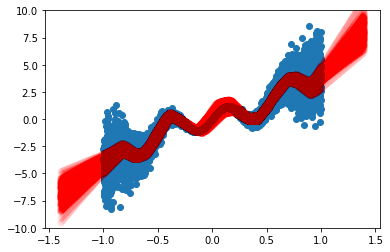

In [49]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

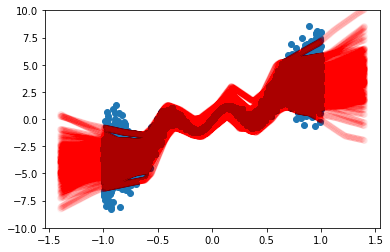

In [20]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)